# Classification Model of Purchase Intentions
### DSCI100 Project Proposal Group 13

## Introduction
With e-commerce becoming more and more prevalent in today’s environment, businesses within this sector need to understand what factors influence a visitor to transform into a purchaser. Hence, a lot of current research is focused on real-time revenue predictors for these businesses.

##### In this project, we aim to build a classification model to predict the purchase intentions of prospective buyers, and determine whether they will make a purchase or not using the available website usage data.

This project uses a dataset from the UCI Machine Learning Repository called the Online Shoppers Purchasing Intention Dataset, which contains information about different users, such as the time spent in each web page and if that lead to a purchase or not.

The dataset consists of 12,330 rows of observations associated with 10 numerical and 8 categorical attributes. The dataset was formed so that each observation (session) would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period.

The attributes in the dataset can be split into three categories: data related to the page that the user lands on, Google Analytics metrics, and user visit data. The 'Revenue' attribute determines whether a session ended in a purchase or not, and would be used as the class label for our project.

## Methods & Results:
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
    - loads data from the original source on the web 
    - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    - performs the data analysis
    - creates a visualization of the analysis 
    - note: all tables and figure should have a figure/table number and a legend

### Importing libraries and reading data

In [2]:
# load packages
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

# set seed
set.seed(3456)

# loading data from the original source on the web
shoppers_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv") %>%
            mutate(Revenue = as_factor(Revenue))
glimpse(shoppers_raw)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Rows: 12,330
Columns: 18
$ Administrative          <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ Administrative_Duration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational_Duration  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ ProductRelated          <dbl> 1, 2, 1, 2, 10, 19, 1, 0, 2, 3, 3, 16, 7, 6, …
$ ProductRelated_Duration <dbl> 0.000000, 64.000000, 0.000000, 2.666667, 627.…
$ BounceRates             <dbl> 0.200000000, 0.000000000, 0.200000000, 0.0500…
$ ExitRates               <dbl> 0.200000000, 0.100000000, 0.200000000, 0.1400…
$ PageValues              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ SpecialDay              <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.8, …
$ Month                   <chr> "Feb", "Feb", "Feb", "Feb", "Feb", "Feb", "Fe…
$ OperatingSystems        <dbl> 1, 2, 4, 3, 3, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, …
$ Browser                 <

### Tidying the data
`shoppers_raw` satisifies the three criteria of tidy data ([Wickham and others 2014](#references)): each row is a single observation, each column is a single variable, and each value is a single cell. Therefore, no further wrangling is needed to make it tidy. 

However, there are 3 potential predictors `VisitorType`，`Weekend` and `Month` that are not numeric that need to be handled.

In [3]:
visitor <- shoppers_raw %>% count(VisitorType)
weekend <- shoppers_raw %>% count(Weekend)
month <- shoppers_raw %>% count(Month)
glimpse(weekend)
glimpse(visitor)
glimpse(month)

Rows: 2
Columns: 2
$ Weekend <lgl> FALSE, TRUE
$ n       <int> 9462, 2868
Rows: 3
Columns: 2
$ VisitorType <chr> "New_Visitor", "Other", "Returning_Visitor"
$ n           <int> 1694, 85, 10551
Rows: 10
Columns: 2
$ Month <chr> "Aug", "Dec", "Feb", "Jul", "June", "Mar", "May", "Nov", "Oct",…
$ n     <int> 433, 1727, 184, 432, 288, 1907, 3364, 2998, 549, 448


- For `VisitorType`, we use `1`, `2`, `3` to represent `"New_Visitor"`, `"Returning_Visitor"`,`"Other"` respectively and store it in a new column `VisitorTypeNumeric`.
- For `Weekend`, we use `1`,`0` to represent `"TRUE`", `"FALSE"` respectively and store it in a new column `WeekendNumeric`.
- For `Month`, we use `1` to `12` to represent each month and store it in a new column `MonthNumeric`.

In [4]:
shoppers <- shoppers_raw %>%
            mutate(VisitorTypeNumeric = case_when(VisitorType == "New_Visitor" ~ 1,
                                                  VisitorType == "Returning_Visitor" ~ 2,
                                                  VisitorType == "Other" ~ 3),
                   WeekendNumeric = case_when(Weekend == "TRUE" ~ 1,
                                              Weekend == "FALSE" ~ 0),
                   MonthNumeric = case_when(Month == "Feb" ~ 2, 
                                            Month == "Mar" ~ 3,
                                            Month == "May" ~ 5,
                                            Month == "June" ~ 6,
                                            Month == "Jul" ~ 7,
                                            Month == "Aug" ~ 8,
                                            Month == "Sep" ~ 9,
                                            Month == "Oct" ~ 10,
                                            Month == "Nov" ~ 11,
                                            Month == "Dec" ~ 12))%>%
            select(- c(Weekend,VisitorType, Month))

shoppers <- shoppers %>%
mutate(Revenue = as.factor(Revenue)) %>%
select(- c(OperatingSystems, Browser, Region, TrafficType, VisitorType, Weekend, Month))

glimpse(shoppers)

ERROR: Error: Can't subset columns that don't exist.
[31m✖[39m Column `VisitorType` doesn't exist.


In [6]:
shoppers <- shoppers_raw %>%
mutate(Revenue = as.factor(Revenue)) %>%
select(- c(OperatingSystems, Browser, Region, TrafficType, VisitorType, Weekend, Month))

glimpse(shoppers)

Rows: 12,330
Columns: 11
$ Administrative          <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ Administrative_Duration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational_Duration  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ ProductRelated          <dbl> 1, 2, 1, 2, 10, 19, 1, 0, 2, 3, 3, 16, 7, 6, …
$ ProductRelated_Duration <dbl> 0.000000, 64.000000, 0.000000, 2.666667, 627.…
$ BounceRates             <dbl> 0.200000000, 0.000000000, 0.200000000, 0.0500…
$ ExitRates               <dbl> 0.200000000, 0.100000000, 0.200000000, 0.1400…
$ PageValues              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ SpecialDay              <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.8, …
$ Revenue                 <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…


Now the wrangled dataframe `shoppers` is ready for the next step.

### Splitting data into training and testing set
Since `shoppers` has a large amount (12330) of observations, it is splitted into a training set `shoppers_train` and a testing set `shoppers_test` with a 50/50 ratio.

In [4]:
shoppers_split <- initial_split(shoppers, prop = 1/2, strata = Revenue)
shoppers_train <- training(shoppers_split)
shoppers_test <- testing(shoppers_split)
glimpse(shoppers_train)
glimpse(shoppers_test)

Rows: 6,165
Columns: 18
$ Administrative          <dbl> 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, …
$ Administrative_Duration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 0,…
$ Informational           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational_Duration  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ ProductRelated          <dbl> 1, 1, 2, 10, 0, 3, 16, 6, 2, 23, 13, 2, 20, 8…
$ ProductRelated_Duration <dbl> 0.000000, 0.000000, 2.666667, 627.500000, 0.0…
$ BounceRates             <dbl> 0.200000000, 0.200000000, 0.050000000, 0.0200…
$ ExitRates               <dbl> 0.200000000, 0.200000000, 0.140000000, 0.0500…
$ PageValues              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ SpecialDay              <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, …
$ OperatingSystems        <dbl> 1, 4, 3, 3, 1, 1, 1, 2, 3, 1, 1, 2, 2, 2, 2, …
$ Browser                 <dbl> 1, 1, 2, 3, 2, 1, 1, 5, 2, 1, 1, 2, 4, 2, 2, …
$ Region                  <d

## Data Analysis

## Pre-processing

In [5]:
shoppers_recipe <- recipe(Revenue ~ . , data = shoppers_train) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors()) %>%
step_upsample(Revenue, over_ratio = 1, skip = TRUE)


Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


### Selecting predictors

In [6]:
shoppers_subset <- shoppers_train
names <- colnames(shoppers_subset %>% select(-Revenue))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
cancer_vfold <- vfold_cv(shoppers_subset, v = 5, strata = Revenue)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Revenue", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        shoppers_recipe <- recipe(as.formula(model_string), data = shoppers_subset) %>%
                          step_upsample(Revenue, over_ratio = 1, skip = TRUE) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors()) 

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(shoppers_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = cancer_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Revenue ~ PageValues,0.8757470
2,Revenue ~ PageValues+MonthNumeric,0.8820742
3,Revenue ~ PageValues+MonthNumeric+VisitorTypeNumeric,0.8862926
⋮,⋮,⋮
15,Revenue ~ PageValues+MonthNumeric+VisitorTypeNumeric+SpecialDay+WeekendNumeric+Region+Informational+TrafficType+Informational_Duration+BounceRates+ProductRelated_Duration+ProductRelated+ExitRates+Browser+OperatingSystems,0.8343884
16,Revenue ~ PageValues+MonthNumeric+VisitorTypeNumeric+SpecialDay+WeekendNumeric+Region+Informational+TrafficType+Informational_Duration+BounceRates+ProductRelated_Duration+ProductRelated+ExitRates+Browser+OperatingSystems+Administrative_Duration,0.8277381
17,Revenue ~ PageValues+MonthNumeric+VisitorTypeNumeric+SpecialDay+WeekendNumeric+Region+Informational+TrafficType+Informational_Duration+BounceRates+ProductRelated_Duration+ProductRelated+ExitRates+Browser+OperatingSystems+Administrative_Duration+Administrative,0.8296852


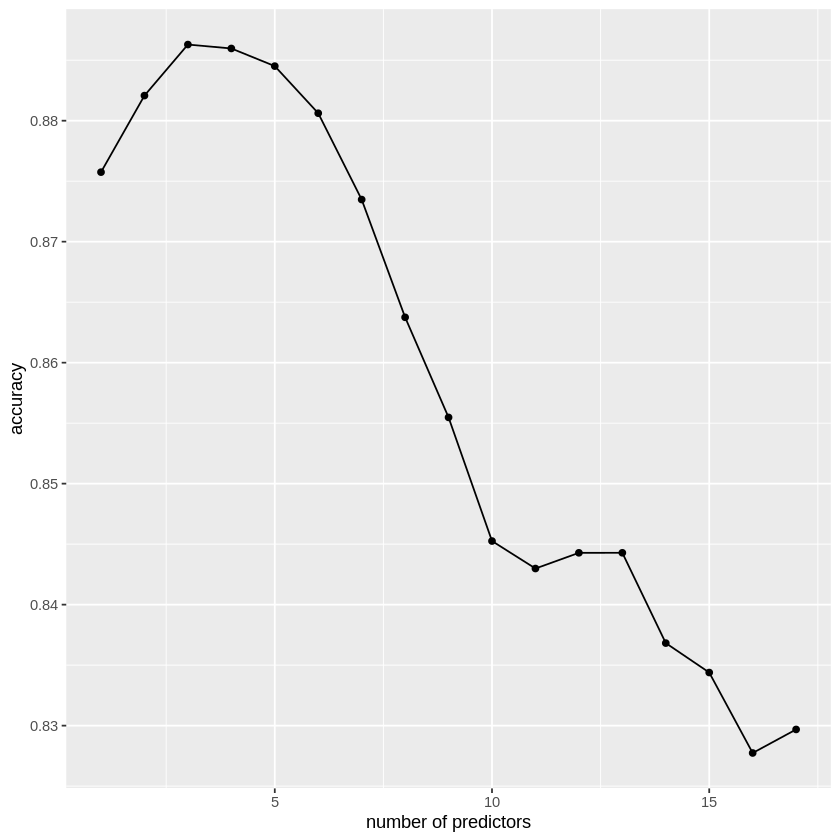

In [7]:
accuracies_plot <- accuracies %>%
                   ggplot(aes(x = size, y = accuracy)) +
                   geom_point() +
                   geom_line() +
                   labs(x = "number of predictors", y = "accuracy")
accuracies_plot

From the graph, we see that the model hits an elbow point and the accuracy starts to fall off after 3 predictors. Hence, that is the set of predictors we would be using for our analysis. 

##### Therefore, our prediction model would be: 

Revenue ~ PageValues + MonthNumeric + VisitorTypeNumeric, where,  

MonthNumeric denotes the month and VisitorTypeNumeric denotes the type of visitor.

## Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## <a id='references'></a>References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

- Wickham, Hadley, and others. 2014. “Tidy Data.” Journal of Statistical Software 59 (10): 1–23.
- Cue consistency and page value perception: Implications for web-based catalog design.
- Analysis of Queues with Impatient Clients: An Application to Online Shopping

In [ ]:
for (i in 1:n_total) {
    ...
    for (j in 1:length(names)) {
       ...
    }
    ...
}